In a previous exercise, we worked with a class called `Datastore` that looked kind of like this:

In [ ]:
import random
from datetime import datetime

class Table():
    def __init__(self):
        self._data = {}
        
    def get(self, key):
        if key not in self._data.keys():
            return None
        
        return self._data[key]
    
    def set(self, key, value):
        self._data[key] = value
        
    def delete(self, key):
        self._data.pop(key)
        
    def __str__(self):
        return str(self._data)
    __repr__ = __str__

However, in the code above I have changed the name `datastore` to `table` because today we will be modifying a database that manages _multiple_ tables! In our example, we will create a database with two tables: one for parrots, and one for parrot owners.

### Suppose you run a pet shop.

You want to partner with local bird clubs to offer customized discounts for their pets. For example "Try out this new birdie boom box! With easy, push-button access to three great tunes. Your parrot Vinny will love it!"<sup>1</sup> 

<sup>1</sup> This is Vinny, a rose-breasted cockatoo (also called a Galah) owned by Marlene McCohen. Marlene shares videos about Vinny and all her other parrots on [her YouTube channel](https://youtu.be/6OmirqidorQ).

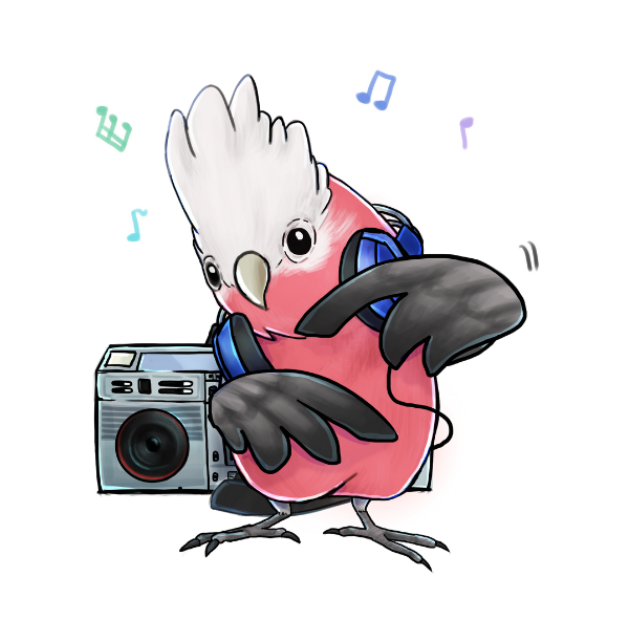

(Sidenote: Vinny probably WOULD love a boom box he could operate. However, **DO NOT** give a bird control over a noise-making device if you ever want to sleep again).

What you DON'T want in your system is a bunch of birds without a recorded owner, because that's just taking up space in your system without giving you a contact person to sell stuff to. So you want to reject uploads from local bird clubs where ANY of the birds in the upload don't have an owner. 

Also, it's easier for the bird clubs to fix their files and re-upload then go back, take out just the invalid rows, and ONLY upload those. So, you reject the whole upload if there's even one problem.

### This is where it would be helpful if our database had  **transactions**.

We use **transactions** in databases to wrap operations and make sure everything is going to proceed properly before we commit the change to the database. That way, we can go through all the birds in the upload, make sure they each have an owner, and accept the upload if they do—or reject the upload if they don't.

In the "real world," developers wrap database operations in transactions as a matter of course, to avoid accidentally corrupting the data.

Let's implement transactions in our database. First we need to have a few exceptions to throw for when a client accidentally asks something weird of the database...

In [ ]:
class NoTransactionInProgressException(Exception):
    def __str__(self):
        return "There isn't a transaction in progress!"
    
class TableAlreadyExistsException(Exception):
    def __str__(self):
        return "A table by that name already exists!"
    
class TableDoesNotExistException(Exception):
    def __str__(self):
        return "No table by that name exists!"

...And here's our implementation of the database class itself. Note that it has the method `create_table` to help a client put  multiple tables in this database. Then it has `begin` to start a transaction, `commit` to save/apply the changes made during a transaction to the real database, and `rollback` to cancel a transaction (and all the changes that happened inside it).

In [ ]:
from copy import deepcopy

class Database():
    def __init__(self):
        self.tables = {}
        self.transaction_tables = {}
        self.transaction_in_progress = False
        
    def create_table(self, name):
        """
        Creates a new table in the database
        
        Inputs:
            name: str - the name of the table
        
        Outputs:
            None
            
        Modifications:
            Adds table to this database
        """
        # Cannot make two tables with the same name
        if name in self.tables.keys():
            raise TableAlreadyExistsException()
        
        # Set the new table name to point to a new table
        self.tables[name] = Table()
        
        # Make an object attribute for the table name,
        # So clients can get a table by doing db.table_name instead of db.tables[table_name]
        setattr(self, name, self.tables[name])
    
    def delete_table(self, name):
        # Cannot delete a nonexistent table
        if name in self.tables.keys():
            raise TableDoesNotExistException()
        
        # delete the old table
        del self.tables[name]
        
        # Remove the object attribute for the table name,
        delattr(self, name)

                
    def begin(self):
        """
        Starts a transaction in the database.
        """
        # Make a copy of every table in the database
        self.transaction_tables = deepcopy(self.tables) 
        
        # Go through the keys and make an object attribute for each table name,
        # So clients can get a table by doing db.table_name instead of db.transaction_tables[table_name]
        for table_name in self.tables.keys():           
            setattr(self, table_name, self.transaction_tables[table_name])
            
        # Indicate to the database that there is a transaction in progress.
        self.transaction_in_progress = True
    
    def commit(self):
        """
        Completes a transaction in the database by saving the changes.
        """
        # If there is no transaction in progress, there is nothing to complete.
        if not self.transaction_in_progress:
            raise NoTransactionInProgressException()
        
        # Save the copied and modified transaction_tables back to the "main" tables variable
        self.tables = self.transaction_tables
        
        # Go through the keys and make an object attribute for each table name,
        # So clients can get a table by doing db.table_name instead of db.tables[table_name]
        for table_name in self.tables.keys():
            setattr(self, table_name, self.tables[table_name])
        
        # Empty out the transaction_tables and 
        # indicate to the database that there is no longer a transaction in progress.
        self.transaction_tables = {}
        self.transaction_in_progress = False
       
    def rollback(self):
        """
        Cancels a transaction in the database by discarding the changes.
        """
        # If there is no transaction in progress, there is nothing to cancel.
        if not self.transaction_in_progress:
            raise NoTransactionInProgressException()
            
        # Go through the keys and make an object attribute for each table name,
        # So clients can get a table by doing db.table_name instead of db.tables[table_name]
        for table_name in self.tables.keys():
            setattr(self, table_name, self.tables[table_name])
            
        # Empty out the transaction_tables and 
        # indicate to the database that there is no longer a transaction in progress.
        self.transaction_tables = {}
        self.transaction_in_progress = False

Here are some automated tests that demonstrate that the transactions work.

In [ ]:
import sys
!{sys.executable} -m pip install colorama 

sys.path.insert(0, '..')
from test_framework_exercise.phoenix_test.matchers import FailedAssertion, Assertion, assert_that
from test_framework_exercise.phoenix_test.test import Test
sys.path.remove('..')

## Tests for Committing Transactions:

In [ ]:
class TransactionAndCommitTest(Test):
    def test_begin_commit__saves_changes(self):
        db = Database()
        db.create_table("birds_on_youtube")
        
        db.begin()
        db.birds_on_youtube.set("Vinny", {"type": "Galah", "owner": "Marlene McCohen", "interests" : "music"})
        db.commit()
        
        assert_that(db.birds_on_youtube.get("Vinny")).equals({"type": "Galah", "owner": "Marlene McCohen", "interests" : "music"})
        assert_that(db.transaction_tables).is_empty()
        
    def test_committing_without_transaction__raises_exception(self):
        db = Database()
        
        try:
            db.commit()
            assert_that("No Exception Thrown").equals("NoTransactionInProgressException")
        except NoTransactionInProgressException:
            return
        
        assert_that("Wrong Exception Thrown").equals("NoTransactionInProgressException")

TransactionAndCommitTest().run()

## Tests for Rolling Back Transactions:

In [ ]:
class TransactionAndRollbackTest(Test):
    def test_rollback_with_transaction__aborts_changes(self):
        db = Database()
        db.create_table("birds_on_youtube")
        
        db.begin()
        db.birds_on_youtube.set("Vinny", {"type": "Galah", "owner": "Marlene McCohen", "interests" : "music"})
        db.rollback()

        assert_that(db.birds_on_youtube.get("Vinny")).equals(None)
        assert_that(db.transaction_tables).is_empty()

    def test_rollback_no_transaction__raises_exception(self):
        db = Database()
        
        try:
            db.rollback()
            assert_that("No Exception Thrown").equals("NoTransactionInProgressException")
        except NoTransactionInProgressException:
            return
        
        assert_that("Wrong Exception Thrown").equals("NoTransactionInProgressException")

TransactionAndRollbackTest().run()

## Here's how we might use database transactions for our pet shop example.

We start a transaction to add a bunch of birds to the database.

Try changing one of the `owner_name`s in `birds_to_add` to a name that does not appear in the `bird_owners` table, and see what gets inserted into `birds_to_add`.

In [ ]:
# Make a Database
db = Database()

# Create a bird_owners table and add bird owners to it
db.create_table('bird_owners')
db.bird_owners.set("Marlene", {"city": "Chatsworth", "email": "mmccohen@sniffers.com"})
db.bird_owners.set("Sister", {"city": "Chatsworth", "email": "mm1234@birdmail.com"})

# Create a birds table
db.create_table('birds')

# Obtain a bird club's records of their members' birds
birds_to_add = {
    "Vinny": {"type": "Galah", "owner_name": "Marlene", "interests": "music"},
    "Picasso": {"type": "Mustache Parakeet", "owner_name": "Marlene", "interests": "fruits"},
    "Jersey": {"type": "Umbrella Cockatoo", "owner_name": "Marlene", "interests": "screaming"},
    "George": {"type": "African Grey", "owner_name": "Marlene", "interests": "books"},
    "Finchey": {"type": "Finch", "owner_name": "Marlene", "interests": "seed"},
    "Rocky": {"type": "Catalina Maccaw", "owner_name": "Marlene", "interests": "dancing"},
    "Leo": {"type": "Red-Lored Amazon", "owner_name": "Marlene", "interests": "Rocky"},
    "Blu": {"type": "Indian Ringneck", "owner_name": "Sister", "interests": "Leo"},
}

# Begin a transaction
db.begin()
num_ownerless_birds = 0

# For every bird, add that bird to the change set if it has an owner
for bird_name, bird in birds_to_add.items():
    if birds_to_add[bird_name]['owner_name'] in db.tables['bird_owners']._data.keys():
        db.birds.set(bird_name, bird)
    else:
        num_ownerless_birds += 1

# If ALL birds have an owner, save the changes by committing.
# Otherwise, cancel the changes by rolling back.
if num_ownerless_birds == 0:
    db.commit()
else:
    db.rollback()

print(db.tables)

Now put it back so that the transaction goes through and the birds are saved, because we need some stuff in the `birds` table for this next part.

Let's calculate how much space the database takes up during a transaction:

In [ ]:
import sys

def get_bytes(tables):
    return sys.getsizeof(str(tables))

def calculate_table_space_for(database):
    return get_bytes(database.tables) + get_bytes(database.transaction_tables)

In [ ]:
db.begin()
calculate_table_space_for(db)

In [ ]:
db.rollback()
calculate_table_space_for(db)

Neither of these numbers is a lot of bytes, but they demonstrate just how space-consuming our current implementation of transactions is. It almost doubles the amount of space we need to store data during a transaction. That would be a problem if we were storing hundeds of thousands of records!

### Challenge: Can you find a way to make transactions work without requiring so much space?

You can modify this copy of the implementation below, in case you want to keep the original one for reference, and then re-run the tests and the use case with the birds above. Whichever implementation of the database is in the cell you ran _last_ is the one that will be used by the Jupyter Notebook.

In [ ]:
from copy import deepcopy

class Database():
    def __init__(self):
        self.tables = {}
        self.transaction_tables = {}
        self.transaction_in_progress = False
        
    def create_table(self, name):
        """
        Creates a new table in the database
        
        Inputs:
            name: str - the name of the table
        
        Outputs:
            None
            
        Modifications:
            Adds table to this database
        """
        # Cannot make two tables with the same name
        if name in self.tables.keys():
            raise TableAlreadyExistsException()
        
        # Set the new table name to point to a new table
        self.tables[name] = Table()
        
        # Make an object attribute for the table name,
        # So clients can get a table by doing db.table_name instead of db.tables[table_name]
        setattr(self, name, self.tables[name])
    
    def delete_table(self, name):
        # Cannot delete a nonexistent table
        if name in self.tables.keys():
            raise TableDoesNotExistException()
        
        # delete the old table
        del self.tables[name]
        
        # Remove the object attribute for the table name,
        delattr(self, name)

                
    def begin(self):
        """
        Starts a transaction in the database.
        """
        # Make a copy of every table in the database
        self.transaction_tables = deepcopy(self.tables) 
        
        # Go through the keys and make an object attribute for each table name,
        # So clients can get a table by doing db.table_name instead of db.transaction_tables[table_name]
        for table_name in self.tables.keys():           
            setattr(self, table_name, self.transaction_tables[table_name])
            
        # Indicate to the database that there is a transaction in progress.
        self.transaction_in_progress = True
    
    def commit(self):
        """
        Completes a transaction in the database by saving the changes.
        """
        # If there is no transaction in progress, there is nothing to complete.
        if not self.transaction_in_progress:
            raise NoTransactionInProgressException()
        
        # Save the copied and modified transaction_tables back to the "main" tables variable
        self.tables = self.transaction_tables
        
        # Go through the keys and make an object attribute for each table name,
        # So clients can get a table by doing db.table_name instead of db.tables[table_name]
        for table_name in self.tables.keys():
            setattr(self, table_name, self.tables[table_name])
        
        # Empty out the transaction_tables and 
        # indicate to the database that there is no longer a transaction in progress.
        self.transaction_tables = {}
        self.transaction_in_progress = False
       
    def rollback(self):
        """
        Cancels a transaction in the database by discarding the changes.
        """
        # If there is no transaction in progress, there is nothing to cancel.
        if not self.transaction_in_progress:
            raise NoTransactionInProgressException()
            
        # Go through the keys and make an object attribute for each table name,
        # So clients can get a table by doing db.table_name instead of db.tables[table_name]
        for table_name in self.tables.keys():
            setattr(self, table_name, self.tables[table_name])
            
        # Empty out the transaction_tables and 
        # indicate to the database that there is no longer a transaction in progress.
        self.transaction_tables = {}
        self.transaction_in_progress = False

### Additional Challenge: Deletion!

We have tried to make transactions take up less space, which is great. We have demonstrated using transactions to add and change things in the tables, which is great. What about _deleting_ things? Here are a few tests to verify that the database implementation can delete tables and rows. 

Which ones pass and which ones fail?

What do you have to do to get them all to pass? Give it a try!

In [ ]:
class DeletionTest(Test):        
    def test_delete_table(self):
        db = Database()
        db.create_table("birds_on_youtube")
        
        db.begin()
        db.delete_table("birds_on_youtube")
        db.commit()
        
        assert_that(db.tables.get('birds_on_youtube') == None)
        assert_that(db.birds_on_youtube == None)
    
    def test_delete_item_commit(self):
        db = Database()
        db.create_table("birds_on_youtube")
        
        db.begin()
        db.birds_on_youtube.set("Vinny", {"type": "Galah", "owner": "Marlene McCohen", "interests" : "music"})
        db.commit()
        
        assert_that(db.birds_on_youtube.get("Vinny")).equals({"type": "Galah", "owner": "Marlene McCohen", "interests" : "music"})
        
        db.begin()
        db.birds_on_youtube.delete("Vinny")
        db.commit()
        
        assert_that(db.birds_on_youtube.get("Vinny") == None)

    def test_delete_item_rollback(self):
        db = Database()
        db.create_table("birds_on_youtube")
        
        db.begin()
        db.birds_on_youtube.set("Vinny", {"type": "Galah", "owner": "Marlene McCohen", "interests" : "music"})
        db.commit()
        
        assert_that(db.birds_on_youtube.get("Vinny")).equals({"type": "Galah", "owner": "Marlene McCohen", "interests" : "music"})
        
        db.begin()
        db.birds_on_youtube.delete("Vinny")
        db.rollback()
        
        db.birds_on_youtube.set("Vinny", {"type": "Galah", "owner": "Marlene McCohen", "interests" : "music"})
        
DeletionTest().run()